In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation_gain_update.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_len = t_pre+t_post
t_sig = 300 # time used for significance test after swim
non_spike_thres = 100
k_spk = boxcarKernel(sigma=61)
k_sub = 10

In [3]:
def search_paired_data(row, flist):
    if 'before' not in row['fish']:
        return False
    fish = row['fish'][:-6]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == fish+'after':
            return True
    return False

def search_paired_data_before(row, flist):
    if 'before ablation' not in row['task']:
        return False
    if 'failed' in row['task']:
        return False
    fish = row['fish'][:-before_len]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == (fish+after_):
            return True
    return False

## Check spike shape

In [4]:
def spk_shape(spk_list, dff):
    spk_ = []
    for t_ in spk_list:
        if t_+30<len(dff):
            spk_.append(dff[t_-30:t_+30])
    spk_ = np.array(spk_)
    return spk_.mean(axis=0)

In [5]:
cell_shape = []
plot_ = False
spk_thres = 150

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
    dat_dir = dir_folder+f'{folder}/{fish}before/Data/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    
    dat_dir = dir_folder+f'{folder}/{fish}after/Data/'
    dff_ = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk_ = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff_ = dff_ - np.nanmedian(dff_, axis=1, keepdims=True)
    num_cell = spk_.shape[0]
    spk_ = np.r_['-1', np.zeros((num_cell, 600)), spk_]
    
    for n_cell in range(num_cell):
        if (spk[n_cell].sum()<spk_thres): # or (spk_[n_cell].sum()<spk_thres)
            continue
        spk_shape_b = spk_shape(np.where(spk[n_cell])[0], dff[n_cell])
        spk_shape_a = spk_shape(np.where(spk_[n_cell])[0], dff_[n_cell])        
        var_ = min(spk_shape_b.std(), spk_shape_a.std())
        err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
        if not np.isnan(err_/var_):
            cell_shape.append(err_/var_)
        if plot_:
            plt.plot(spk_shape_b)
            plt.plot(spk_shape_a)
            var_ = min(spk_shape_b.std(), spk_shape_a.std())
            err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
            plt.title(err_/var_)
            plt.show()

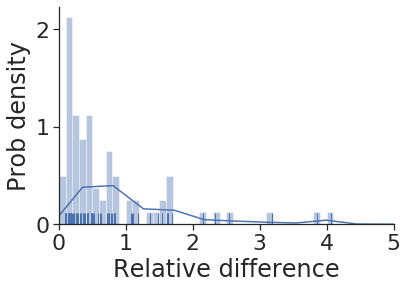

In [6]:
sns.distplot(np.array(cell_shape)**2, hist=True, rug=True, bins=np.arange(0, 10, 0.1))
plt.ylabel('Prob density')
plt.xlabel('Relative difference')
plt.xlim([0, 5])
sns.despine()
plt.show()

## Check spike rates

This analysis is limited to the cell with invariant shape -- relative difference < 1.3

### Low and high gain plot

In [7]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')
k_ = gaussKernel(sigma=7)
gain_stat_len = 300
p_mat_before_ = []
p_mat_after_ = []

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    ##### valid cell
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
    valid_cell = _['valid_cell']
    
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']     
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_ablt_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']
    
    if trial_valid_after.sum()<30:
        continue
    
    ### plot combined
    
    for n_cell in range(sub_swim.shape[0]):
        if not valid_cell[n_cell]:
            continue

        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        gain_stat = np.zeros(t_len)
        if (task_period==2).sum()>0:
            for ntime in range(-t_pre, t_post):
                val, pval= ranksums(spk_list[(task_period==1) & trial_valid, t_pre+ntime], 
                                    spk_list[(task_period==2) & trial_valid, t_pre+ntime])
                gain_stat[ntime] = np.sign(-val) * pval
        p_mat_before_.append(gain_stat)
                
        spk_list = spk_swim_after[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        gain_stat = np.zeros(gain_stat_len)
        if (task_period==2).sum()>0:
            for ntime in range(gain_stat_len):
                val, pval= ranksums(spk_list[(task_period_after==1) & trial_valid_after, t_pre+ntime], 
                                    spk_list[(task_period_after==2) & trial_valid_after, t_pre+ntime])
                gain_stat[ntime] = np.sign(val) * pval
        p_mat_after_.append(gain_stat)

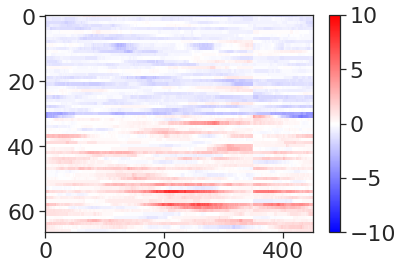

In [8]:
sig_thres = 30
p_mat = np.array(p_mat_before_)
sig_mat = np.abs(p_mat)<0.05
sel_ind = sig_mat.sum(axis=-1)>sig_thres
# p_mat = p_mat[sel_ind]
sig_mat = -np.log(np.abs(p_mat)+1e-10)
sign_mat = np.sign(p_mat)
ind = np.argmax(sig_mat, axis=-1)
sign_ind = np.median(sign_mat, axis=-1)
ind = np.lexsort((ind, sign_ind))
sig_mat = sig_mat*sign_mat
# sig_mat[np.abs(sig_mat)<3] = 0
plt.imshow(sig_mat[ind], aspect='auto',cmap=plt.cm.bwr, vmin=-10, vmax=10)
plt.colorbar()
plt.show()

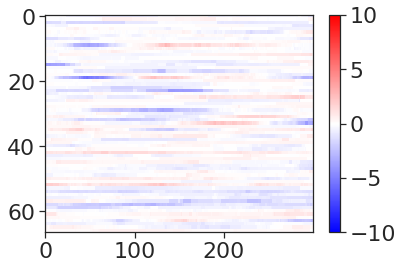

In [9]:
p_mat = np.array(p_mat_after_)
sig_mat = np.abs(p_mat)<0.05
sel_ind_ = sig_mat.sum(axis=-1)>sig_thres
# p_mat = p_mat[sel_ind]
sig_mat = -np.log(np.abs(p_mat)+1e-10)
sign_mat = np.sign(p_mat)
# ind = np.argmax(sig_mat, axis=-1)
# sign_ind = np.median(sign_mat, axis=-1)
# ind = np.lexsort((ind, sign_ind))
sig_mat = sig_mat*sign_mat
# sig_mat[np.abs(sig_mat)<3] = 0
plt.imshow(sig_mat[ind], aspect='auto',cmap=plt.cm.bwr, vmin=-10, vmax=10)
plt.colorbar()
plt.show()

### Combined gain condition

In [10]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')
k_ = gaussKernel(sigma=1)
gain_list = []


cell_before = []
cell_after = []
diff_act = []
plot_ = False

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    ##### valid cell
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
    valid_cell = _['valid_cell']
    
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_ablt_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']
    
    if trial_valid_after.sum()<30:
        continue
    
    ### plot combined
    
    for n_cell in range(sub_swim.shape[0]): 
        if not valid_cell[n_cell]:
            continue
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        
        ave_ = spk_list[trial_valid, :]*300
        ave1 = spk_list[(task_period==1) & trial_valid, :]*300
        ave2 = spk_list[(task_period==2) & trial_valid, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_before.append([np.nanmean(ave_, axis=0), np.nanmean(ave1, axis=0), np.nanmean(ave2, axis=0)])
        diff_act.append((np.nanmean(ave2, axis=0)-np.nanmean(ave1, axis=0)).sum())
        if plot_:
            std_ = sem(ave_, axis=0, nan_policy='omit')
            plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        spk_list = spk_swim_after[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        ave_ = spk_list[trial_valid_after, :]*300
        ave1 = spk_list[(task_period_after==1) & trial_valid_after, :]*300
        ave2 = spk_list[(task_period_after==2) & trial_valid_after, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_after.append([np.nanmean(ave_, axis=0), np.nanmean(ave1, axis=0), np.nanmean(ave2, axis=0)])
        if plot_:
            std_ = sem(ave_, axis=0, nan_policy='omit')
            plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
            plt.xlim([-t_pre/300, t_post/300])
            plt.xlabel('Time (sec)')
            plt.ylabel('dF/F')
            sns.despine()
            plt.title([folder, fish, n_cell])
            plt.show()

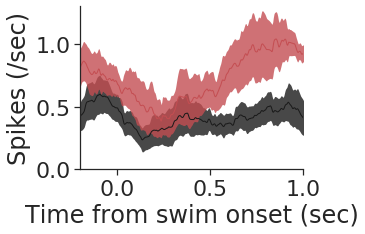

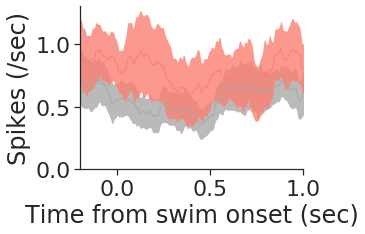

In [14]:
plt.figure(figsize=(4, 3))
tmp_ind = (sel_ind | sel_ind_ ) & (np.array(diff_act)>0)
# tmp_ind = np.ones(len(cellcell_before)).astype('bool')
mean_ = np.mean(np.array(cell_before)[tmp_ind, 1], axis=0)
std_ = sem(np.array(cell_before)[tmp_ind, 1], axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2, label='before abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '-k', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '-k', lw=0.5)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='k')
mean_ = np.mean(np.array(cell_before)[tmp_ind, 2], axis=0)
std_ = sem(np.array(cell_before)[tmp_ind, 2], axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2, label='before abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '-r', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '-r', lw=0.5)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='r')
sns.despine()
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time from swim onset (sec)')
# plt.legend()
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.3])
plt.savefig('../Plots/gain_ablt/pop_ave_before_se.pdf')


plt.figure(figsize=(4, 3))
mean_ = np.mean(np.array(cell_after)[tmp_ind, 1], axis=0)
std_ = sem(np.array(cell_after)[tmp_ind, 1], axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '--k', lw=2, label='after abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)    
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='darkgray')
    
mean_ = np.mean(np.array(cell_after)[tmp_ind, 2], axis=0)
std_ = sem(np.array(cell_after)[tmp_ind, 2], axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '--r', lw=2, label='after abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='salmon')
sns.despine()
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time from swim onset (sec)')
# plt.legend()
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.3])
plt.savefig('../Plots/gain_ablt/pop_ave_after_se.pdf')

## Check Subthreshold activity

### Low and high gain

### Combined trials

In [15]:
t_sig = 300
k_spk = gaussKernel(sigma=3)
k_sub = gaussKernel(sigma=9)

In [16]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')

cell_before = []
cell_after = []
t_label = np.arange(-t_pre, t_post)/300

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']

    ##### valid cell
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
    valid_cell = _['valid_cell']
    
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']  
    swim_starts = _['swim_starts'] 
    trial_valid_ = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid_[n] = False
    trial_valid = trial_valid_.copy()
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    # trial_valid = _['trial_valid']
    
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    swim_starts = _['swim_starts'] 
    trial_valid_ = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid_[n] = False
    trial_valid_after = trial_valid_.copy()
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_ablt_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    # trial_valid_after = _['trial_valid']
    
    if trial_valid_after.sum()<30:
        continue
    
    ### plot combined
        
    for n_cell in range(sub_swim.shape[0]):
        if not valid_cell[n_cell]:
            continue
        
        sub_sig = sub_sig_swim[n_cell]
        sub_list = sub_swim[n_cell]
        tmp = []
        for n_spk in sub_list:
            tmp.append(smooth(n_spk, k_sub))
        sub_list = np.array(tmp)
        # sub_list = sub_list - sub_list[:, 0:70].mean(axis=-1, keepdims=True) # (t_pre-30):t_pre
        sub_list = sub_list - sub_list[:, (t_pre-60):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
            
        ave_ = sub_list[(task_period==1) & trial_valid, :]*100
        mean_ = np.nanmedian(ave_, axis=0)
        cell_before.append(mean_)
        sub_sig = sub_sig_swim_after[n_cell]
        sub_list = sub_swim_after[n_cell]
        sub_list = sub_list - sub_list[:, 0:70].mean(axis=-1, keepdims=True)
        spk_list = spk_swim_after[n_cell]
        
        ave_ = sub_list[(task_period_after==1) & trial_valid_after, :]*100
        mean_pre = mean_
        mean_ = np.nanmedian(ave_, axis=0)
        if np.abs(mean_).max()/np.abs(mean_pre).max()>2:
            ff = 5 #np.abs(mean_).max()/np.abs(mean_pre).max()
        else:
            ff = 1
        mean_ = mean_/ff
        cell_after.append(mean_)

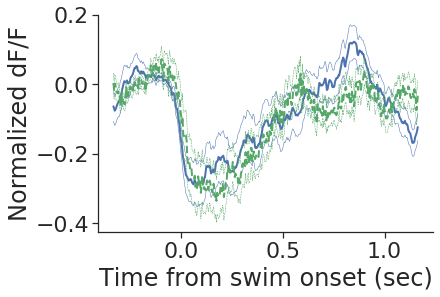

In [17]:
from scipy.stats import sem
act_ = np.array(cell_before)
ff = np.abs(act_).max(axis=-1, keepdims=True)
act_ = act_ / ff
mean_ = np.mean(act_, axis=0)
std_ = sem(act_, axis=0)
plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-b', lw=2, label='before abltion')
plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '-b', lw=0.5)
plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '-b', lw=0.5)

act_ = np.array(cell_after)
act_ = act_ / ff
mean_ = np.mean(act_, axis=0)
std_ = sem(act_, axis=0)
plt.plot(np.arange(-t_pre, t_post)/300, mean_, '--g', lw=2, label='after abltion')
plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--g', lw=0.5)
plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--g', lw=0.5)

sns.despine()
plt.ylabel('Normalized dF/F')
plt.xlabel('Time from swim onset (sec)')
# plt.legend()
plt.show()

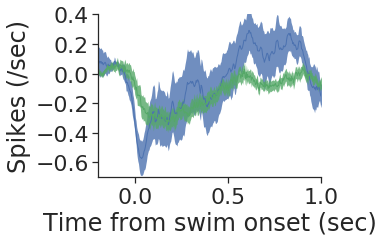

In [18]:
from scipy.stats import sem
plt.figure(figsize=(4, 3))
act_ = np.array(cell_before)
ff = np.abs(act_).max(axis=-1, keepdims=True)
act_ = act_ / ff
mean_ = np.mean(act_[tmp_ind], axis=0)
std_ = sem(act_[tmp_ind], axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-b', lw=2, label='before abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '-b', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '-b', lw=0.5)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='b')

act_ = np.array(cell_after)
act_ = act_ / ff
mean_ = np.mean(act_, axis=0)
std_ = sem(act_, axis=0)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_, '--g', lw=2, label='after abltion')
# plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--g', lw=0.5)
# plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--g', lw=0.5)
shaded_errorbar(np.arange(-t_pre, t_post)/300, mean_, std_, color='g')

sns.despine()
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time from swim onset (sec)')
# plt.legend()
plt.xlim([-0.2, 1.0])
plt.ylim([-0.7, 0.4])
plt.yticks(np.arange(-0.6, 0.6, 0.2))
plt.savefig('../Plots/gain_ablt/pop_ave_sub_se.pdf')